# Proyecto Time Series:

In [63]:
# Librería para la declaración y uso de Data Frames:
import pandas as pd

# Librería para poder hacer gráficos:
import matplotlib.pyplot as plt

# Librería para poder realizar operaciones matemáticas:
import numpy as np


## Paso 1 - Lectura de Datos:

En primer lugar, es necesario **leer y guardar la información** en una variable para poder empezar a trabajar con ella.

Para ello, se ha guaradado el archivo con todos los datos en la ruta: */workspaces/time-series--clara-ab/data/raw/sales.csv* y se ha cargado en un Data Frame:

In [64]:
# Lectura del CSV con los datos, dada la ruta donde se guarda el archivo:
df = pd.read_csv ('/workspaces/time-series--clara-ab/data/raw/sales.csv');

# Configuración de pandas para mostrar todas las columnas del DataFrame sin truncarlas al visualizarlo
pd.set_option('display.max_columns', None);

# Se muestran las 5 primeras filas del Data Frame
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


Una vez se ha cargado correctamente la información en el Data Frame es interesante evaluar la **cantidad de información** que se tiene. Para ello, se recurre al atributo `.shape` del Data Frame:

In [65]:
# Se utiliza el atributo shape del Data Frame para conocer cuánta información está cargada:
print (f" El conjunto de datos cuenta con información de {df.shape[0]} ventas con total de {df.shape[1]} tipos de información sobre ellas");

 El conjunto de datos cuenta con información de 366 ventas con total de 2 tipos de información sobre ellas


Si se estudia el conjunto de datos, se puede observar que hay **dos variables**: 

- `date` : Día y hora exacta de registro de la venta

- `sales` : Total vendido

Para poder trabajar con esta información, es necesario saber bien qué **tipo de datos** son:

In [66]:
# Se imprime el tipo de dato de cada característica:
df.dtypes

date      object
sales    float64
dtype: object

Como se ha podido observar, la **fecha y hora exacta** del registro de venta no es del tipo `DateTime`, si no que es un **objeto**. Por ello, en primer lugar, se va a realizar este **cambio de variable**:

In [67]:
# Se realiza un cambio de variable de la columna `date`:
df['date'] = pd.to_datetime(df['date'])
df.dtypes

date     datetime64[ns]
sales           float64
dtype: object

Además, como se ha podido ver, hay **un registro por día a lo largo de un año** (Tensor: 1 día), desde el 3 de Septiembre del 2022 hasta el 3 de septiembre del 2023 pero **siempre se realiza dicho registro a la misma hora**.

Esto implica que dentro de la variable `date` **solo interesa la fecha**, **no la hora**, por lo que se puede eliminar para tratar con los datos de forma más ágil. 

In [68]:
# Solo se guarda la fecha:
df['date'] = df['date'].dt.date
df.head()

,date,sales
0,2022-09-03,55.292157
1,2022-09-04,53.803211
2,2022-09-05,58.141693
3,2022-09-06,64.530899
4,2022-09-07,66.013633


## Paso 2 - Análisis Exploratorio de Datos:

Antes de realizar cualquier tipo de predicción, es fundamental llevar a cabo un **análisis de los datos** para poder identificar **patrones**, detectar **valores atípicos** y evaluar la **distribución** de las variables para comprender la **relación** entre ellas.

Por este motivo, se van a realizar distintos pasos cuyo objetivo final es **preparar el conjunto de datos para poder trabajar con ellos**. Este EDA va a ser breve, no se va a explicar en detalle como se ha venido haciendo en los proyectos anteriores. Simplemente se irá paso a paso realizando un estudio y solo se hará un breve comentario al final con las decisiones que se hayan tomado.

### Paso 2.1 - Análisis de Constantes y Duplicados:

In [50]:
# Se utiliza el método .nunique() para saber la cantidad de columnas con constantes en el Data Frame:
print(f" Hay un total de {(lambda df: (df.nunique() == 1).sum())(df)} columnas en el Data Frame con un valor constante para todas las ventas");

# Se imprime el conteo de valores distintos en cada columna:
print (f" \nPara cada columna del Data Frame, se muestran cuántos valores distintos presentan:");
df.nunique()

 Hay un total de 0 columnas en el Data Frame con un valor constante para todas las ventas
 
Para cada columna del Data Frame, se muestran cuántos valores distintos presentan:


date     366
sales    366
dtype: int64

A partir del resultado obtenido se puede observar que **no hay ninguna constante** en los datos cargados, por lo tanto no hay que eliminar ninguna columna, como era de esperar al tener solo la fecha+hora y el número total de la venta. 

In [51]:
# Se utiliza el método .duplicated() para identificar las ventas repetidas dentro del DataFrame:
print(f" Hay un total de {df.duplicated().sum()} ventas duplicadass.");

 Hay un total de 0 ventas duplicadass.


### Paso 2.2 - Análisis Estadístico:

In [52]:
# Descripción estadística básica de todas las columnas del DataFrame:
df.describe(include='all').T # Se traspone para ver de forma más clara los datos

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date,366,366,2023-09-03,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sales,366.0,NaN,NaN,NaN,524.963968,275.089698,53.803211,290.186822,520.699468,763.289263,1000.482785


En este caso, lo que se quería comprobar es que no se contaban con **datos de ventas negativos o iguales a 0**, dado que serían errores. **No se ha encontrado nada de este tipo**, por lo que no se hace ningún filtrado en base a este análisis. 

### Paso 2.3 - Análisis de Nulos:

In [53]:
# Se comprueba el porcentaje de ventas que presentan al menos un valor nulo:
print(f" El {round(df.isnull().any(axis=1).mean()*100, 2)} % de las ventas presenta, al menos, un valor nulo en alguna de sus características descriptivas");

 El 0.0 % de las ventas presenta, al menos, un valor nulo en alguna de sus características descriptivas


**No hay ningún nulo** dentro del conjunto de datos.

## Paso 3 - Construcción y Análisis de la Serie Temporal:

Una vez se tiene el conjunto de datos preparado para el análisis, es interesante realizar un estudio para ver cuál es el **comportamiento del escenario**. 

Para ello, en primer lugar, se va a trazar una **gráfica simple** de forma que se pueda ver la **tendencia de ventas a lo largo de un año**:

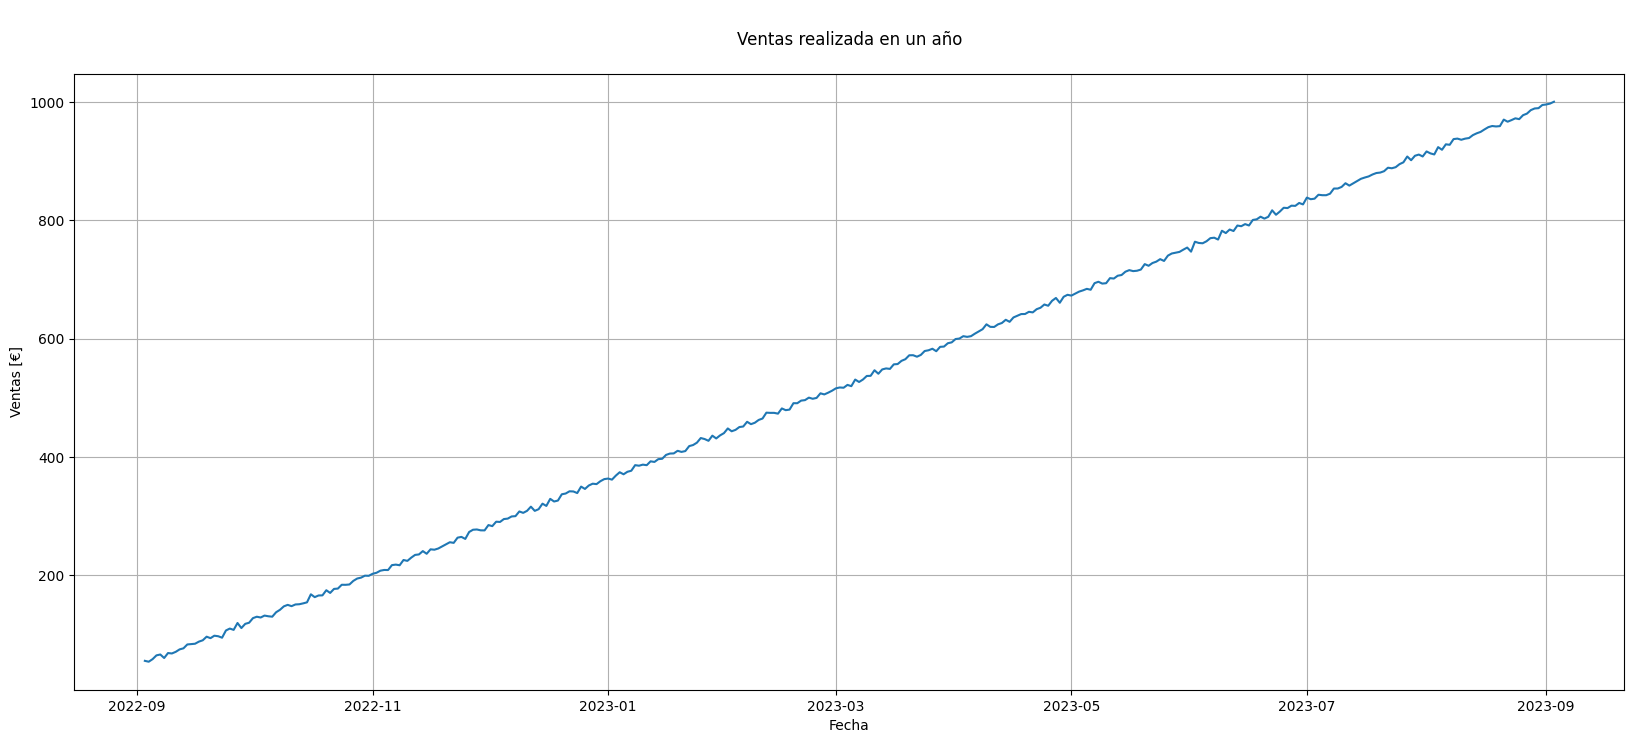

In [82]:
# Se genera la figura: 
plt.figure (figsize = (20,8));

# Se grafica la línea de tendencia:
plt.plot(df.date, df.sales);
plt.xlabel ('Fecha');
plt.ylabel('Ventas [€]');
plt.title ('\nVentas realizada en un año\n');
plt.grid(True);

# Se muestra: 
plt.show()

El negocio **no ha parado de crecer** desde su apertura. La tendencia de las ventas ha sido **inequívocamente ascencente**, solo habiendo ligeras fluctuaciones en momentos puntuales. 

Para poder analizar *más de cerca* esas pequeñas variaciones, se va a obtener **una gráfica por mes**. Con este objetivo, se van a generar **dos nuevas variables**, `month` y `day` de forma que se puedan **filtrar** e ir recorriendo para ver la **tendencia mensual**:

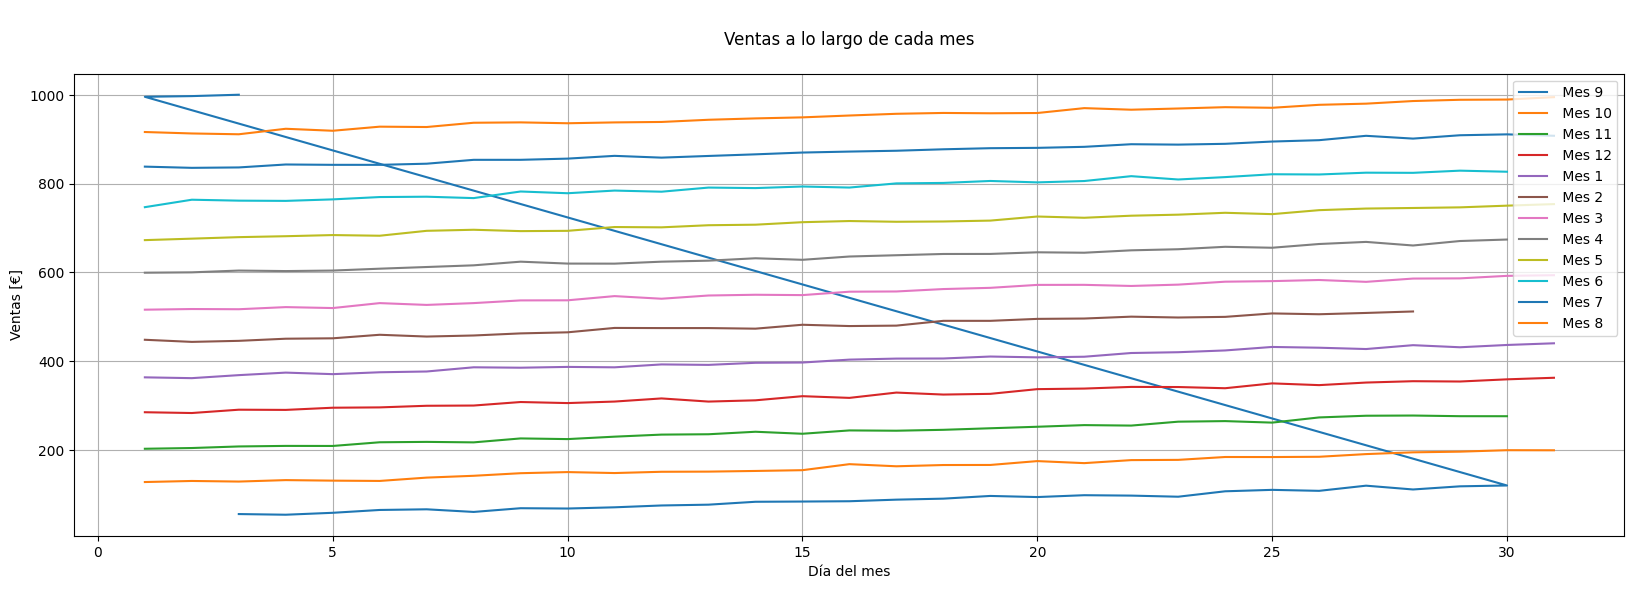

In [83]:
# Se vuelve a convertir la variable `date` de DateTime:
df['date'] = pd.to_datetime(df['date']);

# Se obtiene el mes:
df['month'] = df['date'].dt.month;

# Se obtiene el día:
df['day'] = df['date'].dt.day;

# Se genera la figura:
plt.figure(figsize=(20, 6))

# Se recorren todos los meses del conjunto de datos:
for month in df['month'].unique(): 

    # Se filtra el mes sobre el que se está iterando:
    df_month = df[df['month'] == month];

    # Se grafica la venta del día concreto del mes:
    plt.plot(df_month['day'], df_month['sales'], label = f" Mes {month}");


# Se añade información:
plt.xlabel("Día del mes");
plt.ylabel("Ventas [€]");
plt.title("\nVentas a lo largo de cada mes\n")
plt.legend();
plt.grid(True);

# Se muestra la gráfica:
plt.show();

Lo primero que es importante aclarar es que el conjunto de datos **empieza y acaba en Septiembre**, es decir, Mes 9. Es por esta razón por la cual la **línea correspondiente está tanto en los valores más bajos** (peores ventas) **como en los más altos** (mejores ventas). El **primer caso** hace referencia a los datos relativos a la **apertura** del negocio y el **último** a los resultados **al cabo de un año**. 

A parte de esto, **no hay nada destacable en cuanto a tendencias dentro de un mismo mes**. Se ve que hay ligeras fluctuaciones pero ninguna es habitual en todos los meses. 

Por otro lado, para estudiar la **estacionalidad y la presencia de ruido**, no es tan sencillo como analizar la tendencia. Con este objetivo, se va a utilizar la función `seasonal_decompose` de la librería  `statsmodel`, de forma que se pueda **descomponer la serie temporal** bajo estudio en sus **componentes principales** (volverá a aparecer la tendencia, pero va a ser útil para reafirmar el análisis previo):

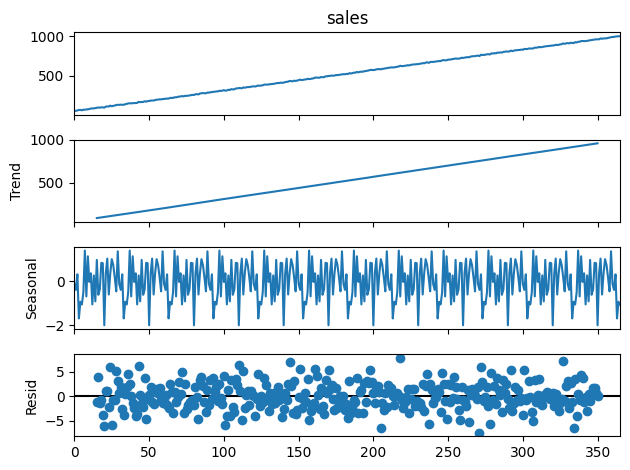

In [91]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df.sales, model='additive', period=30)  # Ajusta "period" según los datos
result.plot()
plt.show()